In [1]:
import torch
from torch import nn
from torch import optim
from matplotlib import pyplot as plt
from torch.utils.dlpack import from_dlpack
import random
random.seed(42)
import cupy as cp
cp.random.seed(42)

In [2]:
def in_mandelbrot(c, max_iter = 10000):
    z = 0
    for i in range(max_iter):
        if z.real**2+z.imag**2 >= 4: return False
        z = z**2 + c
    return True

def data_fn(max_val = 1, size = 1000):
    x = []
    y = []
    for i in range(size):
        c = complex(random.uniform(-max_val, max_val), random.uniform(-max_val, max_val))
        x.append([c.real, c.imag])
        y.append([1.0 if in_mandelbrot(c) else 0.0])
    return torch.tensor(x), torch.tensor(y)

x, y = data_fn()
print(f'x.shape: {x.shape} x.dtype: {x.dtype}')
print(f'y.shape: {y.shape} y.dtype: {y.dtype}')

x.shape: torch.Size([1000, 2]) x.dtype: torch.float32
y.shape: torch.Size([1000, 1]) y.dtype: torch.float32


In [3]:
# a much faster implementation of the above (if you have a beefy GPU that is)
def fast_data_fn(max_val = 1, size = 1000):
    max_iter = 10000
    x = cp.random.uniform(-max_val, max_val, (size, 2), dtype=cp.float32)
    y = cp.ElementwiseKernel(
        'float32 c_re, float32 c_im, int32 max_iter',
        'float32 out',
        '''
        out = 1;
        float z_re = 0;
        float z_im = 0;
        for (int i = 0; i < max_iter; i++) {
            if (z_re*z_re + z_im*z_im >= 4) {
                out = 0;
                break;
            }
            float z_re_new = z_re*z_re - z_im*z_im;
            float z_im_new = 2*z_re*z_im;
            
            z_re = z_re_new + c_re;
            z_im = z_im_new + c_im;
        }
        ''')(x[:, 0], x[:, 1], max_iter)
    y = cp.expand_dims(y, axis=-1)
    return from_dlpack(x.toDlpack()), from_dlpack(y.toDlpack())
x, y = fast_data_fn()
print(f'x.shape: {x.shape} x.dtype: {x.dtype}')
print(f'y.shape: {y.shape} y.dtype: {y.dtype}')

x.shape: torch.Size([1000, 2]) x.dtype: torch.float32
y.shape: torch.Size([1000, 1]) y.dtype: torch.float32


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def train(data_fn, model, loss_fn, optimizer, iterations, print_every=100):
    model.train()
    losses = []
    accuracies = []
    for i in range(iterations):
        x, y = data_fn()
        x, y = x.to(device), y.to(device)
        
        pred = model(x)
        loss = loss_fn(pred, y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        accuracies.append(((pred > 0.5) == y).sum().item() / len(y))
        
        if i % print_every == 0:
            
            # note we don't need to look at the validation metrics since each training data set
            # is randomly generated
            print(f'iteration {i}: loss {losses[-1]} accuracy: {accuracies[-1]}')
            
    return losses, accuracies
def test(data, model, loss_fn):
    model.eval()
    with torch.no_grad():
        x, y = data
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)
        return loss.item()

In [8]:
model = nn.Sequential(
    nn.Linear(2, 64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.ReLU(),
    nn.Linear(8, 1),
    nn.Sigmoid()
)
model.to(device)
# binary cross entropy loss
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters())
losses, accuracies = train(fast_data_fn, model, loss_fn, optimizer, 100000, print_every=1000)

iteration 0: loss 0.7854639291763306 accuracy: 0.346
iteration 1000: loss 0.09835053235292435 accuracy: 0.959
iteration 2000: loss 0.08494889736175537 accuracy: 0.966
iteration 3000: loss 0.0744866356253624 accuracy: 0.974
iteration 4000: loss 0.06476710736751556 accuracy: 0.981
iteration 5000: loss 0.04849540442228317 accuracy: 0.978
iteration 6000: loss 0.04451014846563339 accuracy: 0.978
iteration 7000: loss 0.03864714875817299 accuracy: 0.983
iteration 8000: loss 0.06010521948337555 accuracy: 0.975
iteration 9000: loss 0.046351924538612366 accuracy: 0.977
iteration 10000: loss 0.051589854061603546 accuracy: 0.977
iteration 11000: loss 0.05282476916909218 accuracy: 0.979
iteration 12000: loss 0.042627543210983276 accuracy: 0.985
iteration 13000: loss 0.04442218318581581 accuracy: 0.979
iteration 14000: loss 0.04839157685637474 accuracy: 0.979
iteration 15000: loss 0.04190972447395325 accuracy: 0.98
iteration 16000: loss 0.04151661694049835 accuracy: 0.982
iteration 17000: loss 0.044

[]

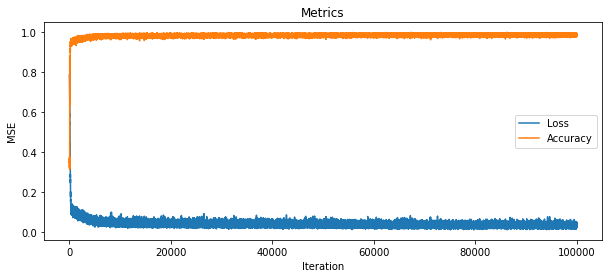

In [9]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(losses, label='Loss')
ax.plot(accuracies, label='Accuracy')
ax.set_xlabel('Iteration')
ax.set_ylabel('MSE')
ax.set_title('Metrics')
ax.legend()
plt.plot()

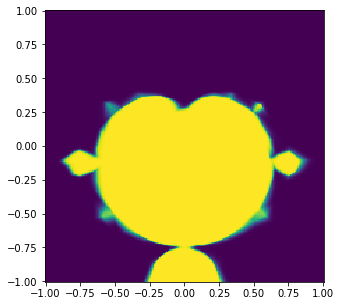

In [13]:
def make_xsys(xs, ys):
    # Given two vectors (of shape (n) and (m)), return a tensor of shape
    # (n, m, 2) such that T[i, j, :] are the (x, y) coordinates at point [i, j].
    return torch.stack(torch.meshgrid(xs, ys), dim=-1).type(torch.float)

# Make 100 equally spaced x and y points in the range [-1, 2]. Feed all the
# (x, y) pairs into the model, then convert to a Numpy array. The resulting
# tensor will have shape (n, m, 1) instead of (n, m), so squeeze the last
# coordinate away.
xs = ys = torch.linspace(-1, 1, 200).to(device)
values = model(make_xsys(xs, ys)).detach()[:, :, 0]

# Plot the heatmap of the model, and an ad-hoc scatterplot of the XOR points.
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.pcolormesh(xs.cpu(), ys.cpu(), values.cpu())
plt.show()